# Libraries to be used in this project.

In [1]:
import pandas as pd 
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer
import ast
from nltk.stem.porter import PorterStemmer
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
from rake_nltk import Rake
from nltk.corpus import stopwords
import string
import spacy

nltk.download('vader_lexicon')
nltk.download('stopwords')
# !python -m spacy download en_core_web_sm

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\doruk\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\doruk\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
movies_big = "datasets/extended-dataset/tmdb10000.csv"
movies_small = "datasets/extended-dataset/tmdb7000.csv"

In [3]:
movies_big_df = pd.read_csv(movies_big)
movies_small_df = pd.read_csv(movies_small)

# Data Peek

## Example of the dataset

In [7]:
movies_big_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   TMDb_Id               10000 non-null  int64  
 1   IMDb_Id               9929 non-null   object 
 2   Title                 10000 non-null  object 
 3   Original_Title        10000 non-null  object 
 4   Overview              9970 non-null   object 
 5   Genres                9934 non-null   object 
 6   Cast                  9948 non-null   object 
 7   Crew                  9987 non-null   object 
 8   Collection            9999 non-null   object 
 9   Release_Date          9997 non-null   object 
 10  Release_Status        9999 non-null   object 
 11  Original_Language     10000 non-null  object 
 12  Languages_Spoken      9916 non-null   object 
 13  Runtime               9986 non-null   float64
 14  Tagline               7597 non-null   object 
 15  Popularity          

## Columns to drop: TMDb_Id, IMDB_Id, Original_Title, Collection, Release_Status, Language_Spoken, Country_of_Origin, Crew

In [27]:
movies_big_df.drop('TMDb_Id', axis=1, inplace=True)
movies_big_df.drop('IMDb_Id', axis=1, inplace=True)
movies_big_df.drop('Original_Title', axis=1, inplace=True)
movies_big_df.drop('Release_Status', axis=1, inplace=True)
movies_big_df.drop('Crew', axis=1, inplace=True)

In [34]:
movies_big_df.columns

Index(['Title', 'Overview', 'Genres', 'Cast', 'Collection', 'Release_Date',
       'Original_Language', 'Languages_Spoken', 'Runtime', 'Tagline',
       'Popularity', 'Rating_average', 'Rating_Count', 'Production_Companies',
       'Country_of_Origin', 'Budget', 'Revenue'],
      dtype='object')

## Columns to merge to create extended overview: Title, Overview, Genres, Cast, Collection, Tagline, Production Companies

In [35]:
movies_big_df['extended_overview'] = movies_big_df['Title'].astype(str)+ " " + movies_big_df['Overview'].astype(str) + movies_big_df['Genres'].astype(str) + movies_big_df['Cast'].astype(str) + movies_big_df['Collection'].astype(str) + movies_big_df['Tagline'].astype(str) + movies_big_df['Production_Companies'].astype(str)

### How does extended overview look like.

In [36]:
movies_big_df['extended_overview'][1]

"Bloodshot After he and his wife are murdered, marine Ray Garrison is resurrected by a team of scientists. Enhanced with nanotechnology, he becomes a superhuman, biotech killing machine—'Bloodshot'. As Ray first trains with fellow super-soldiers, he cannot recall anything from his former life. But when his memories flood back and he remembers the man that killed both him and his wife, he breaks out of the facility to get revenge, only to discover that there's more to the conspiracy than he thought.Action | Science FictionVin Diesel | Eiza González | Sam Heughan | Toby Kebbell | Talulah Riley | Lamorne Morris | Guy Pearce | Jóhannes Haukur Jóhannesson | Alex Hernandez | Siddharth Dhananjay | Tamer Burjaq | Clyde Berning | David Dukas | Tyrel Meyer | Alex Anlos | Maarten Römer | Patrick Kerton | Ryan KrugerSingleBeing a superhero is in his bloodSony Pictures | Cross Creek Pictures | Mimran Schur Pictures | Original Film | The Hideaway Entertainment | Valiant Entertainment | Columbia Pict

### We will remove stopwords and symbols out of the text.

In [17]:
def stopword_punct_remover_nltk(text):
    # Tokenize the text
    tokens = nltk.word_tokenize(text)

    # Remove stopwords and symbols from the list of tokens
    filtered_tokens = [token for token in tokens if token.lower() not in stopwords.words('english') and token not in string.punctuation]

    # Join the filtered tokens to form a new text
    filtered_text = ' '.join(filtered_tokens)

    return filtered_text

In [37]:
movies_big_df['extended_overview'] = movies_big_df['extended_overview'].apply(stopword_punct_remover_nltk)

In [38]:
movies_big_df['extended_overview'] = movies_big_df['extended_overview'].str.lower()

### Data after removing stopwords and symbols and lowercase letter.

In [70]:
movies_big_df['extended_overview'][1]

"bloodshot wife murdered marine ray garrison resurrected team scientists enhanced nanotechnology becomes superhuman biotech killing machine—'bloodshot ray first trains fellow super-soldiers recall anything former life memories flood back remembers man killed wife breaks facility get revenge discover 's conspiracy thought.action science fictionvin diesel eiza gonzález sam heughan toby kebbell talulah riley lamorne morris guy pearce jóhannes haukur jóhannesson alex hernandez siddharth dhananjay tamer burjaq clyde berning david dukas tyrel meyer alex anlos maarten römer patrick kerton ryan krugersinglebeing superhero bloodsony pictures cross creek pictures mimran schur pictures original film hideaway entertainment valiant entertainment columbia pictures one race bona film group"

# How to recommend?

## Define the recommender function based on the demand.

In [40]:
movies_big_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 18 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Title                 10000 non-null  object 
 1   Overview              9970 non-null   object 
 2   Genres                9934 non-null   object 
 3   Cast                  9948 non-null   object 
 4   Collection            9999 non-null   object 
 5   Release_Date          9997 non-null   object 
 6   Original_Language     10000 non-null  object 
 7   Languages_Spoken      9916 non-null   object 
 8   Runtime               9986 non-null   float64
 9   Tagline               7597 non-null   object 
 10  Popularity            10000 non-null  float64
 11  Rating_average        10000 non-null  float64
 12  Rating_Count          10000 non-null  int64  
 13  Production_Companies  9697 non-null   object 
 14  Country_of_Origin     9882 non-null   object 
 15  Budget              

In [48]:
def general_recommender(df, 
budget=300000, 
language='en', 
popularity=31, 
revenue= 800000, 
runtime= 106, 
min_vote_avg = 6, 
max_vote_avg = 10, 
vote_count = 300):

    df_filtered = df[(df['Budget'] >= budget) &  (df['Original_Language'] == language) & (df['Popularity'] >= popularity) & (df['Revenue'] >= revenue) & (df['Runtime'] >= runtime) & (df['Rating_average'] >= min_vote_avg) & (df['Rating_Count'] >= vote_count) & (df['Rating_average'] <= max_vote_avg)]
    return df_filtered[['Title', 'Rating_average']]

In [53]:
def user_input_recommender(df, 
user_input="", 
budget=100, 
popularity=15, 
revenue= 80000, 
runtime= 20,
min_vote_avg = 4,
vote_count = 100):


    # Create an instance of the CountVectorizer
    vectorizer = CountVectorizer()
    
    # Fit and transform the dataframe column and user input
    texts = df['extended_overview'].tolist()
    texts.append(user_input)
    vectors = vectorizer.fit_transform(texts).toarray()

    # Calculate the cosine similarity between user input and each row in the dataframe
    similarities = cosine_similarity(vectors)[-1][:-1]

    df["similarity"] = similarities

    # Filter the dataframe based on the similarity score
    df_filtered = df[(df['budget'] >= budget) &  
    (df['Popularity'] >= popularity) & 
    (df['Revenue'] >= revenue) & 
    (df['Runtime'] >= runtime) & 
    (df['Rating_average'] >= min_vote_avg) & 
    (df['Rating_Count'] >= vote_count)]

    df_sorted = df_filtered.sort_values(by='similarity', ascending = False)


    return df_sorted[['Title', 'Rating_average', 'similarity']]

In [43]:
# Load the spacy model
nlp = spacy.load("en_core_web_sm")

# Define the sentence
sentence = "This is an example sentence with keywords"

# Process the sentence with spacy
doc = nlp(sentence)

# Extract the keywords
keywords = [token.text for token in doc if not token.is_stop and not token.is_punct]

# Print the keywords
print(keywords)

['example', 'sentence', 'keywords']


In [54]:
def user_input_recommender_keywords(df, 
user_input="", 
budget=100, 
popularity=15, 
revenue= 80000, 
runtime= 20,
min_vote_avg = 4,
vote_count = 100):

    nlp = spacy.load("en_core_web_sm")
    doc = nlp(user_input)
    keywords = [token.text for token in doc if not token.is_stop and not token.is_punct]
    for keyword in keywords:
        user_input += (" "+ keyword)
    # Create an instance of the CountVectorizer
    vectorizer = CountVectorizer()

    # Fit and transform the dataframe column and user input
    texts = df['extended_overview'].tolist()
    texts.append(user_input)
    vectors = vectorizer.fit_transform(texts).toarray()


    # Calculate the cosine similarity between user input and each row in the dataframe
    similarities = cosine_similarity(vectors)[-1][:-1]

    df["similarity"] = similarities

    # Filter the dataframe based on the similarity score
    df_filtered = df[(df['budget'] >= budget) &  
    (df['Popularity'] >= popularity) & 
    (df['Revenue'] >= revenue) & 
    (df['Runtime'] >= runtime) & 
    (df['Rating_average'] >= min_vote_avg) & 
    (df['Rating_Count'] >= vote_count)]

    df_sorted = df_filtered.sort_values(by='similarity', ascending = False)


    return df_sorted[['Title', 'Rating_average', 'similarity']]

In [65]:
def user_input_recommender_sentiment(df, 
user_input="", 
budget=100, 
popularity=15, 
revenue= 80000, 
runtime= 20,
min_vote_avg = 4,
vote_count = 100):

    user_input = user_input.lower()

    genres_keywords = {
        "action": ["mission", "chase", "explosion"],
        "adventure": ["journey", "discovery", "epic"],
        "animation": ["cartoon","3D", "stop-motion"],
        "biography": ["true story", "real-life", "historical"],
        "comedy": ["humor", "joke", "parody"],
        "crime": ["detective", "investigation", "murder"],
        "documentary": ["factual", "non-fiction", "real-life"],
        "drama": ["emotional", "intense", "serious"],
        "family": ["kids", "children", "parents"],
        "fantasy": ["magic", "mythical", "enchanted"],
        "film-noir": ["crime", "mystery", "darkness"],
        "history": ["historical", "period", "true story"],
        "horror": ["scares", "terror", "suspense"],
        "music": ["songs", "bands", "musicians"],
        "musical": ["songs", "dancing", "choreography"],
        "mystery": ["detective", "investigation", "crime"],
        "romance": ["love", "passion", "heartbreak"],
        "sci-fi": ["science", "technology", "space"],
        "sport": ["competition", "athletes", "teams"],
        "superhero": ["powers", "abilities", "costume"],
        "thriller": ["suspense", "tension", "danger"],
        "mission": ["action", "chase", "explosion"],
        "journey": ["adventure", "discovery", "epic"],
        "cartoon": ["animation", "3D", "stop-motion"],
        "true story": ["biography", "real-life", "historical"],
        "humor": ["comedy", "joke", "parody"],
        "detective": ["mystery", "investigation", "crime"],
        "factual": ["documentary", "non-fiction", "real-life"],
        "emotional": ["drama", "intense", "serious"],
        "kids": ["family", "children", "parents"],
        "magic": ["fantasy", "mythical", "enchanted"],
        "crime": ["film-noir", "mystery", "darkness"],
        "historical": ["history", "period", "true story"],
        "scares": ["horror", "terror", "suspense"],
        "songs": ["musical", "dancing", "choreography"],
        "love": ["romance", "passion", "heartbreak"],
        "science": ["sci-fi", "technology", "space"],
        "competition": ["sport", "athletes", "teams"],
        "powers": ["superhero", "abilities", "costume"],
        "suspense": ["thriller", "tension", "danger"],    
        "war": ["battle", "conflict", "soldiers"],
        "western": ["gunslingers", "outlaws", "cowboys"],
        "post-apocalyptic": ["survival", "end of the world", "disaster"],
        "dystopian": ["totalitarian", "government control", "oppression"],
        "cyberpunk": ["technology", "artificial intelligence", "virtual reality"],
        "space opera": ["space", "aliens", "spaceships"],
        "time travel": ["past", "future", "time machine"],
        "vampire": ["immortality", "blood", "vampire hunter"],
        "zombie": ["undead", "apocalypse", "survival"],
        "ghost": ["paranormal", "haunting", "spirits"],
        "haunted house": ["ghosts", "spirits", "paranormal"],
        "supernatural": ["ghosts", "spirits", "paranormal"],
        "pirate": ["sea", "ships", "treasure"],
        "spy": ["espionage", "secret agent", "secrecy"],
        "historical fiction": ["historical events", "real-life figures", "period piece"],
        "political thriller": ["political", "conspiracy", "power"],
        "psychological thriller": ["mind", "manipulation", "brainwashing"],
        "crime thriller": ["crime", "investigation", "suspense"],
        "coming of age": ["growing up", "adolescence", "self-discovery"],
        "road trip": ["travel", "adventure", "self-discovery"],
        "romantic comedy": ["love", "romance", "dating"],
        "battle": ["war", "conflict", "soldiers"],
        "gunslingers": ["western", "outlaws", "cowboys"],
        "survival": ["post-apocalyptic", "end of the world", "disaster"],
        "totalitarian": ["dystopian", "government control", "oppression"],
        "technology": ["cyberpunk", "artificial intelligence", "virtual reality"],
        "space": ["space opera", "aliens", "spaceships"],
        "past": ["time travel", "future", "time machine"],
        "immortality": ["vampire", "blood", "vampire hunter"],
        "undead": ["zombie", "apocalypse", "survival"],
        "paranormal": ["ghost", "haunting", "spirits"],
        "ghosts": ["supernatural", "spirits", "paranormal"],
        "sea": ["pirate", "ships", "treasure"],
        "espionage": ["spy", "secret agent", "secrecy"],
        "historical events": ["historical fiction","real-life figures","period piece"],
        "political": ["political thriller", "conspiracy", "power"],
        "mind": ["psychological thriller", "manipulation", "brainwashing"],
        "crime": ["crime thriller", "investigation", "suspense"],
        "growing up": ["coming of age", "adolescence", "self-discovery"],
        "travel": ["road trip", "adventure", "self-discovery"],
        "love": ["romantic comedy", "romance", "dating"],
        "black comedy": ["dark humor", "satire", "irony"],
        "stand-up comedy": ["stand-up", "comedy", "humor"],
        "slapstick comedy": ["physical comedy", "humor", "jokes"],
        "action comedy": ["action", "comedy", "fun"],
        "disaster": ["destruction", "catastrophe", "emergency"],
        "political satire": ["politics", "government", "satire"],
        "social satire": ["society", "culture", "satire"],
        "psychological horror": ["mind", "manipulation", "brainwashing"],
        "dark humor": ["black comedy", "satire", "irony"],
        "stand-up": ["stand-up comedy", "comedy", "humor"],
        "physical comedy": ["slapstick comedy", "humor", "jokes"],
        "action": ["action comedy", "comedy", "fun"],
        "destruction": ["disaster", "catastrophe", "emergency"],
        "politics": ["political satire", "government", "satire"],
        "society": ["social satire", "culture", "satire"],
        "mind": ["psychological horror", "manipulation", "brainwashing"]  
    }

    nlp = spacy.load("en_core_web_sm")
    doc = nlp(user_input)
    keywords = [token.text for token in doc if not token.is_stop and not token.is_punct]

    sia = SentimentIntensityAnalyzer()
    sentence = user_input
    sentiment_score = sia.polarity_scores(sentence)
    neg_score = sentiment_score['neg']
    
    
    populated_keywords = keywords
    # If neg score is smaller than 0.5 then user wants a movie about this category.
    # We populate the search with similar terms.
    if neg_score < 0.35:
        for keyword in keywords:
            if keyword in genres_keywords:
                populated_keywords += genres_keywords[keyword][0]
                populated_keywords += genres_keywords[keyword][1]
                populated_keywords += genres_keywords[keyword][2]
    elif neg_score > 0.35:
        # If neg score is bigger than 0.5 that means user do not want anything about
        # extracted keywords so we give them other categories.
        new_keywords = list(genres_keywords.keys() - populated_keywords)
        for keyword in new_keywords:
            if keyword in genres_keywords:
                new_keywords += genres_keywords[keyword][0]
                new_keywords += genres_keywords[keyword][1]
                new_keywords += genres_keywords[keyword][2]
        
        populated_keywords = new_keywords[0:5]
        user_input = ""

        


    for keyword in populated_keywords:
        user_input += (" "+ keyword)
    # Create an instance of the CountVectorizer
    vectorizer = CountVectorizer()

    # Fit and transform the dataframe column and user input
    texts = np.array(df['extended_overview'])
    np.append(texts, np.array(user_input))
    vectors = vectorizer.fit_transform(texts).toarray()


    # Calculate the cosine similarity between user input and each row in the dataframe
    similarities = cosine_similarity(vectors)[-1][:-1]

    df["similarity"] = similarities

    # Filter the dataframe based on the similarity score
    df_filtered = df[(df['Budget'] >= budget) &  
    (df['Popularity'] >= popularity) & 
    (df['Revenue'] >= revenue) & 
    (df['Runtime'] >= runtime) & 
    (df['Rating_average'] >= min_vote_avg) & 
    (df['Rating_Count'] >= vote_count)]

    df_sorted = df_filtered.sort_values(by='similarity', ascending = False)


    return df_sorted[['Title', 'Rating_average', 'similarity']]

# An example of how we tried to enrich user input with keywords and generated keywords.

### "action": ["mission", "chase", "explosion"],
### "adventure": ["journey", "discovery", "epic"],

    "animation": ["cartoon","3D", "stop-motion"],
    "biography": ["true story", "real-life", "historical"],
    "comedy": ["humor", "joke", "parody"],
    "crime": ["detective", "investigation", "murder"],
    "documentary": ["factual", "non-fiction", "real-life"],
    "drama": ["emotional", "intense", "serious"],
    "family": ["kids", "children", "parents"],
    "fantasy": ["magic", "mythical", "enchanted"],
    .
    .
    .
    

dictionery_reverse = {}
for key in genres_keywords_example.keys():
    dictionery_reverse[genres_keywords_example[key][0]] = [key] + [genres_keywords_example[key][1], genres_keywords_example[key][2]]



### 'mission': ['action', 'chase', 'explosion'],
### 'journey': ['adventure', 'discovery', 'epic'],
 'cartoon': ['animation', '3D', 'stop-motion'],
 'true story': ['biography', 'real-life', 'historical'],
 'humor': ['comedy', 'joke', 'parody'],
 'detective': ['mystery', 'investigation', 'crime'],
 'factual': ['documentary', 'non-fiction', 'real-life'],
 'emotional': ['drama', 'intense', 'serious'],
 'kids': ['family', 'children', 'parents'],
 'magic': ['fantasy', 'mythical', 'enchanted'],
.
.
.

# Model Comparisons

### 1) General Recommender
### 2) User input recommender
### 3) User input recommender with keywords
### 4) User input recommender with keywords enriched and sentiments

In [52]:
general_recommender(movies_big_df).head(5)

,Title,Rating_average
1,Bloodshot,7.2
3,Ant-Man,7.1
5,Birds of Prey (and the Fantabulous Emancipatio...,7.1
6,Live Free or Die Hard,6.5
10,Jumanji: The Next Level,6.8


In [60]:
user_input_recommender(movies_big_df, user_input="A detective story.")

MemoryError: Unable to allocate 8.32 GiB for an array with shape (10001, 111700) and data type int64

In [61]:
user_input_recommender_keywords(movies_big_df, user_input="A detective story.")

MemoryError: Unable to allocate 8.32 GiB for an array with shape (10001, 111700) and data type int64

In [66]:
user_input_recommender_sentiment(movies_big_df, user_input="A detective story.")

MemoryError: Unable to allocate 8.32 GiB for an array with shape (10000, 111700) and data type int64


# Data Peek

In [6]:
movies_big_df.describe()

,TMDb_Id,Runtime,Popularity,Rating_average,Rating_Count,Budget,Revenue
count,10000.000000,9986.000000,10000.000000,10000.000000,10000.000000,9.999000e+03,9.999000e+03
mean,152075.912000,102.805928,13.615456,6.307200,1021.559700,1.906091e+07,5.560842e+07
std,196845.093333,26.501851,10.428176,1.352637,1993.732127,3.559811e+07,1.439128e+08
min,2.000000,0.000000,4.838000,0.000000,0.000000,0.000000e+00,0.000000e+00
25%,10165.250000,91.000000,9.739750,5.800000,143.000000,0.000000e+00,0.000000e+00
50%,27124.000000,101.000000,11.620500,6.500000,332.000000,3.000000e+06,2.500000e+06
75%,301366.750000,115.000000,14.334000,7.100000,927.000000,2.300000e+07,4.611674e+07
max,688131.000000,400.000000,463.487000,10.000000,25159.000000,3.870000e+08,2.797801e+09


In [5]:
movies_big_df.head(5)

,TMDb_Id,IMDb_Id,Title,Original_Title,Overview,Genres,Cast,Crew,Collection,Release_Date,...,Languages_Spoken,Runtime,Tagline,Popularity,Rating_average,Rating_Count,Production_Companies,Country_of_Origin,Budget,Revenue
0,419704,tt2935510,Ad Astra,Ad Astra,"The near future, a time when both hope and har...",Drama | Science Fiction,Brad Pitt | Tommy Lee Jones | Ruth Negga | Joh...,Brad Pitt | Arnon Milchan | Gary Rydstrom | Ga...,Single,2019-09-17,...,English | Norsk,123.0,The answers we seek are just outside our reach,463.487,5.9,2863,New Regency Productions | Keep Your Head | Mad...,Brazil | China | United States of America,87500000.0,127175922.0
1,338762,tt1634106,Bloodshot,Bloodshot,"After he and his wife are murdered, marine Ray...",Action | Science Fiction,Vin Diesel | Eiza González | Sam Heughan | Tob...,John Papsidera | Matthew Vaughn | Jim May | Ne...,Single,2020-03-05,...,English,110.0,Being a superhero is in his blood,235.701,7.2,1384,Sony Pictures | Cross Creek Pictures | Mimran ...,China | United States of America,42000000.0,24573617.0
2,38700,tt1502397,Bad Boys for Life,Bad Boys for Life,Marcus and Mike are forced to confront new thr...,Action | Crime | Thriller,Will Smith | Martin Lawrence | Paola Nuñez | V...,Jerry Bruckheimer | Mike Stenson | Chad Oman |...,Bad Boys Collection,2020-01-15,...,Español | English,124.0,Ride together. Die together.,255.068,7.1,2596,Columbia Pictures | Platinum Dunes | 2.0 Enter...,France | United States of America,0.0,191150000.0
3,102899,tt0478970,Ant-Man,Ant-Man,Armed with the astonishing ability to shrink i...,Action | Adventure | Science Fiction,Paul Rudd | Michael Douglas | Evangeline Lilly...,David Lazan | Jackie Burch | Sala Baker | Sala...,Ant-Man Collection,2015-07-14,...,English,117.0,Heroes don't get any bigger.,134.294,7.1,13625,Marvel Studios,United States of America,130000000.0,519311965.0
4,76285,tt1854564,Percy Jackson: Sea of Monsters,Percy Jackson: Sea of Monsters,"In their quest to confront the ultimate evil, ...",Adventure | Fantasy | Family,Logan Lerman | Alexandra Daddario | Douglas Sm...,Mark Goldblatt | Shelly Johnson | Karen Rosenf...,Percy Jackson Collection,2013-08-07,...,English,106.0,"Where There Are Gods, There Are Monsters.",124.417,5.9,3547,Fox 2000 Pictures | Sunswept Entertainment | 1...,United States of America,90000000.0,199850315.0


In [101]:
credits_path = "datasets/tmdb5000/tmdb_5000_credits.csv"
movies_path = "datasets/tmdb5000/tmdb_5000_movies.csv"

In [102]:
movies = pd.read_csv(movies_path)
credits = pd.read_csv(credits_path)


# Data Peek

## Examples of the dataset

In [103]:
movies.head(2)

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count
0,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.avatarmovie.com/,19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2009-12-10,2787965087,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800
1,300000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...",http://disney.go.com/disneypictures/pirates/,285,"[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2007-05-19,961000000,169.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500


In [104]:
credits.head()

,movie_id,title,cast,crew
0,19995,Avatar,"[{""cast_id"": 242, ""character"": ""Jake Sully"", ""...","[{""credit_id"": ""52fe48009251416c750aca23"", ""de..."
1,285,Pirates of the Caribbean: At World's End,"[{""cast_id"": 4, ""character"": ""Captain Jack Spa...","[{""credit_id"": ""52fe4232c3a36847f800b579"", ""de..."
2,206647,Spectre,"[{""cast_id"": 1, ""character"": ""James Bond"", ""cr...","[{""credit_id"": ""54805967c3a36829b5002c41"", ""de..."
3,49026,The Dark Knight Rises,"[{""cast_id"": 2, ""character"": ""Bruce Wayne / Ba...","[{""credit_id"": ""52fe4781c3a36847f81398c3"", ""de..."
4,49529,John Carter,"[{""cast_id"": 5, ""character"": ""John Carter"", ""c...","[{""credit_id"": ""52fe479ac3a36847f813eaa3"", ""de..."


In [105]:
movies.describe().round(1)

,budget,id,popularity,revenue,runtime,vote_average,vote_count
count,4803.0,4803.0,4803.0,4.803000e+03,4801.0,4803.0,4803.0
mean,29045039.9,57165.5,21.5,8.226064e+07,106.9,6.1,690.2
std,40722391.3,88694.6,31.8,1.628571e+08,22.6,1.2,1234.6
min,0.0,5.0,0.0,0.000000e+00,0.0,0.0,0.0
25%,790000.0,9014.5,4.7,0.000000e+00,94.0,5.6,54.0
50%,15000000.0,14629.0,12.9,1.917000e+07,103.0,6.2,235.0
75%,40000000.0,58610.5,28.3,9.291719e+07,118.0,6.8,737.0
max,380000000.0,459488.0,875.6,2.787965e+09,338.0,10.0,13752.0


In [106]:
movies.shape

(4803, 20)

In [107]:
movies.columns

Index(['budget', 'genres', 'homepage', 'id', 'keywords', 'original_language',
       'original_title', 'overview', 'popularity', 'production_companies',
       'production_countries', 'release_date', 'revenue', 'runtime',
       'spoken_languages', 'status', 'tagline', 'title', 'vote_average',
       'vote_count'],
      dtype='object')

In [108]:
movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4803 entries, 0 to 4802
Data columns (total 20 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   budget                4803 non-null   int64  
 1   genres                4803 non-null   object 
 2   homepage              1712 non-null   object 
 3   id                    4803 non-null   int64  
 4   keywords              4803 non-null   object 
 5   original_language     4803 non-null   object 
 6   original_title        4803 non-null   object 
 7   overview              4800 non-null   object 
 8   popularity            4803 non-null   float64
 9   production_companies  4803 non-null   object 
 10  production_countries  4803 non-null   object 
 11  release_date          4802 non-null   object 
 12  revenue               4803 non-null   int64  
 13  runtime               4801 non-null   float64
 14  spoken_languages      4803 non-null   object 
 15  status               

In [109]:
movies.corr()

,budget,id,popularity,revenue,runtime,vote_average,vote_count
budget,1.000000,-0.089377,0.505414,0.730823,0.269851,0.093146,0.593180
id,-0.089377,1.000000,0.031202,-0.050425,-0.153536,-0.270595,-0.004128
popularity,0.505414,0.031202,1.000000,0.644724,0.225502,0.273952,0.778130
revenue,0.730823,-0.050425,0.644724,1.000000,0.251093,0.197150,0.781487
runtime,0.269851,-0.153536,0.225502,0.251093,1.000000,0.375046,0.271944
vote_average,0.093146,-0.270595,0.273952,0.197150,0.375046,1.000000,0.312997
vote_count,0.593180,-0.004128,0.778130,0.781487,0.271944,0.312997,1.000000


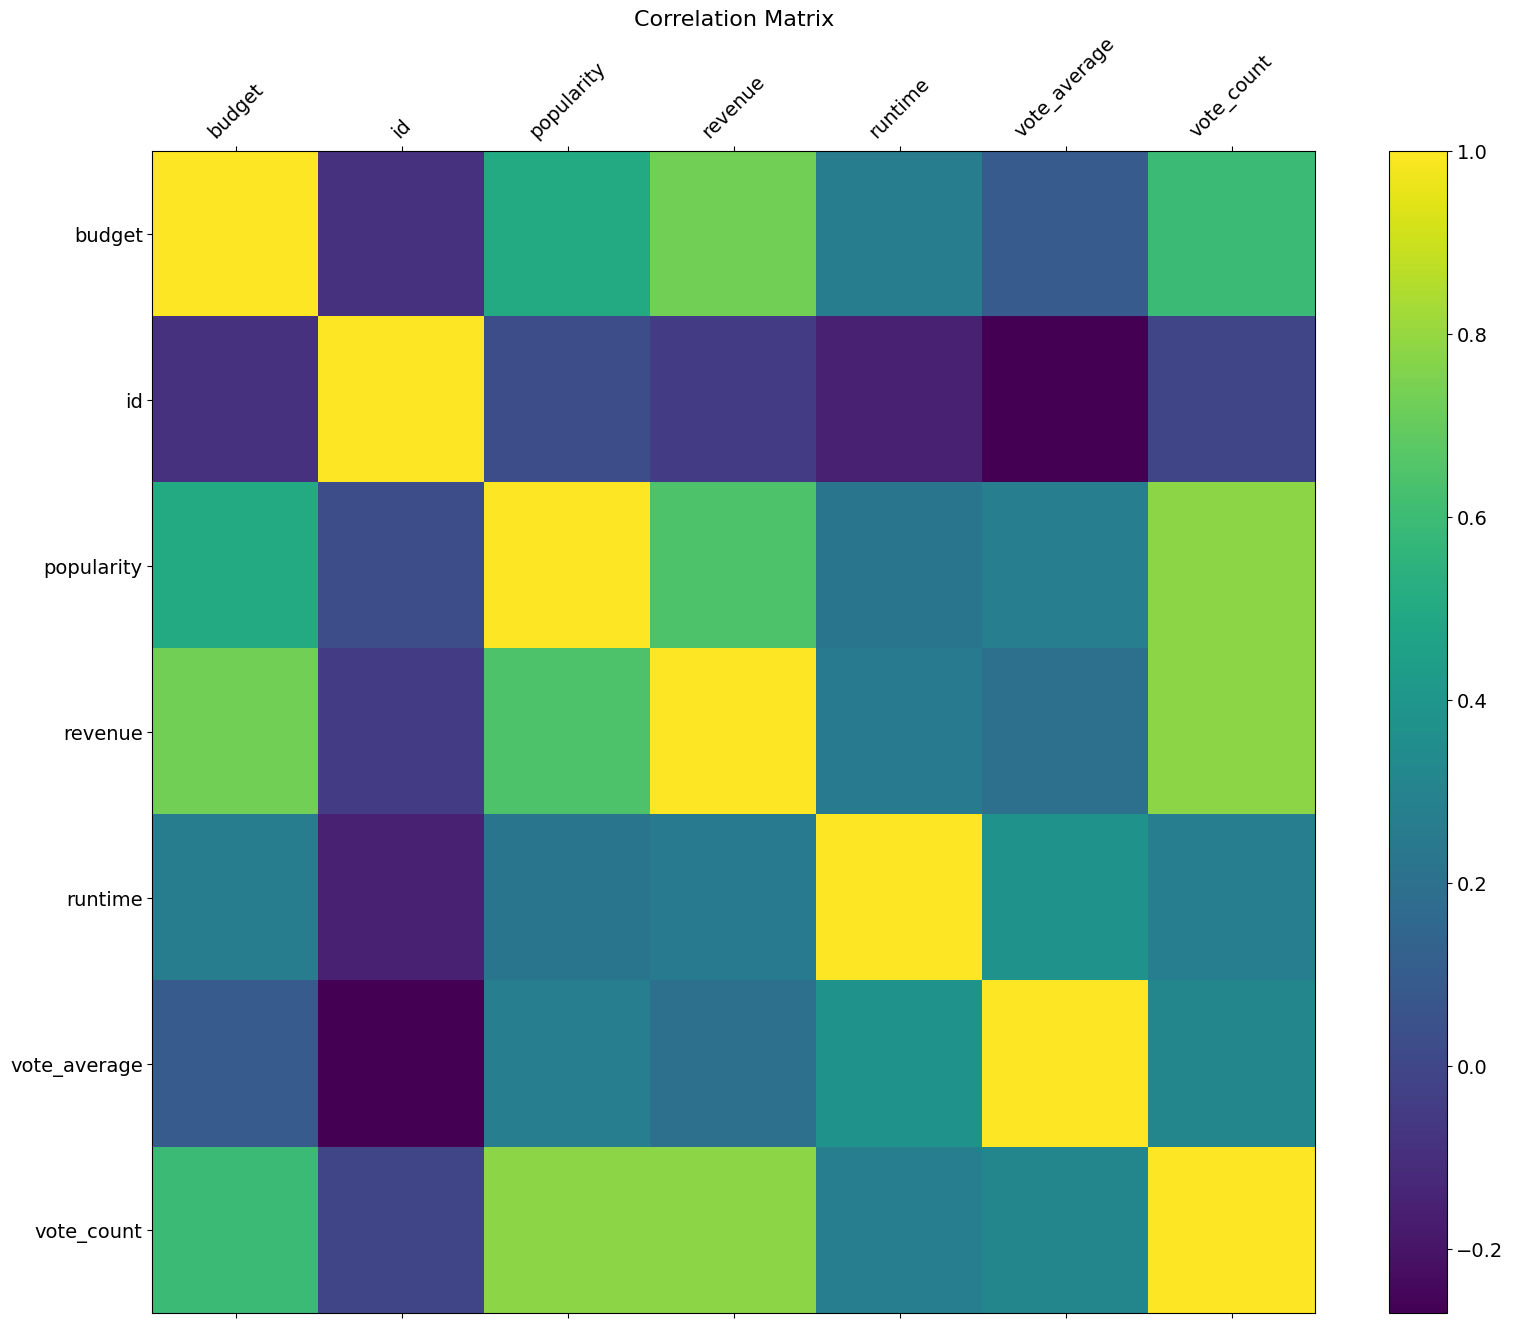

In [110]:
f = plt.figure(figsize=(19, 15))
plt.matshow(movies.corr(), fignum=f.number)
plt.xticks(range(movies.select_dtypes(['number']).shape[1]), movies.select_dtypes(['number']).columns, fontsize=14, rotation=45)
plt.yticks(range(movies.select_dtypes(['number']).shape[1]), movies.select_dtypes(['number']).columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Correlation Matrix', fontsize=16);

### We will remove some of these features and do some preprocessing on keywords and other features since it is not going to contribute in recommending the movie or we will need them in different forms.

In [111]:
movies_clean_path = "datasets/tmdb-clean/tmdb_5000_movies_clean.csv"
movies_clean = pd.read_csv(movies_clean_path)

In [112]:
movies_clean.corr()

,budget,popularity,revenue,runtime,vote_average,vote_count
budget,1.000000,0.505414,0.730823,0.269851,0.093146,0.593180
popularity,0.505414,1.000000,0.644724,0.225502,0.273952,0.778130
revenue,0.730823,0.644724,1.000000,0.251093,0.197150,0.781487
runtime,0.269851,0.225502,0.251093,1.000000,0.375046,0.271944
vote_average,0.093146,0.273952,0.197150,0.375046,1.000000,0.312997
vote_count,0.593180,0.778130,0.781487,0.271944,0.312997,1.000000


In [113]:
movies_clean.head(2)

,title,budget,genres,keywords,original_language,overview,popularity,production_companies,revenue,runtime,tagline,vote_average,vote_count
0,Avatar,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...","[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...",2787965087,162.0,Enter the World of Pandora.,7.2,11800
1,Pirates of the Caribbean: At World's End,300000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...","[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...",en,"Captain Barbossa, long believed to be dead, ha...",139.082615,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...",961000000,169.0,"At the end of the world, the adventure begins.",6.9,4500


In [114]:
# Duplicated data check
movies_clean.duplicated().sum()

0

In [115]:
movies_clean.describe()

,budget,popularity,revenue,runtime,vote_average,vote_count
count,4.803000e+03,4803.000000,4.803000e+03,4801.000000,4803.000000,4803.000000
mean,2.904504e+07,21.492301,8.226064e+07,106.875859,6.092172,690.217989
std,4.072239e+07,31.816650,1.628571e+08,22.611935,1.194612,1234.585891
min,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,0.000000
25%,7.900000e+05,4.668070,0.000000e+00,94.000000,5.600000,54.000000
50%,1.500000e+07,12.921594,1.917000e+07,103.000000,6.200000,235.000000
75%,4.000000e+07,28.313505,9.291719e+07,118.000000,6.800000,737.000000
max,3.800000e+08,875.581305,2.787965e+09,338.000000,10.000000,13752.000000


Change from json to list of keywords and genres.

In [116]:
def converter(obj):
    genreList = []
    for i in ast.literal_eval(obj):
        genreList.append(i['name'])
    return genreList

movies_clean['genres'] = movies_clean['genres'].apply(converter)
movies_clean['keywords'] = movies['keywords'].apply(converter)
movies_clean['production_companies'] = movies['production_companies'].apply(converter)

In [117]:
movies_clean.head(2)

,title,budget,genres,keywords,original_language,overview,popularity,production_companies,revenue,runtime,tagline,vote_average,vote_count
0,Avatar,237000000,"[Action, Adventure, Fantasy, Science Fiction]","[culture clash, future, space war, space colon...",en,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[Ingenious Film Partners, Twentieth Century Fo...",2787965087,162.0,Enter the World of Pandora.,7.2,11800
1,Pirates of the Caribbean: At World's End,300000000,"[Adventure, Fantasy, Action]","[ocean, drug abuse, exotic island, east india ...",en,"Captain Barbossa, long believed to be dead, ha...",139.082615,"[Walt Disney Pictures, Jerry Bruckheimer Films...",961000000,169.0,"At the end of the world, the adventure begins.",6.9,4500


In [118]:
movies_clean['overview']

0       In the 22nd century, a paraplegic Marine is di...
1       Captain Barbossa, long believed to be dead, ha...
2       A cryptic message from Bond’s past sends him o...
3       Following the death of District Attorney Harve...
4       John Carter is a war-weary, former military ca...
                              ...                        
4798    El Mariachi just wants to play his guitar and ...
4799    A newlywed couple's honeymoon is upended by th...
4800    "Signed, Sealed, Delivered" introduces a dedic...
4801    When ambitious New York attorney Sam is sent t...
4802    Ever since the second grade when he first saw ...
Name: overview, Length: 4803, dtype: object

In [119]:
movies_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4803 entries, 0 to 4802
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   title                 4803 non-null   object 
 1   budget                4803 non-null   int64  
 2   genres                4803 non-null   object 
 3   keywords              4803 non-null   object 
 4   original_language     4803 non-null   object 
 5   overview              4800 non-null   object 
 6   popularity            4803 non-null   float64
 7   production_companies  4803 non-null   object 
 8   revenue               4803 non-null   int64  
 9   runtime               4801 non-null   float64
 10  tagline               3959 non-null   object 
 11  vote_average          4803 non-null   float64
 12  vote_count            4803 non-null   int64  
dtypes: float64(3), int64(3), object(7)
memory usage: 487.9+ KB


In [120]:
movies_clean['general_overview'] =movies_clean['overview'].astype(str) + movies_clean['keywords'].astype(str) + movies_clean['genres'].astype(str) + movies_clean['title'].astype(str)

In [121]:
movies_clean.head(2)

,title,budget,genres,keywords,original_language,overview,popularity,production_companies,revenue,runtime,tagline,vote_average,vote_count,general_overview
0,Avatar,237000000,"[Action, Adventure, Fantasy, Science Fiction]","[culture clash, future, space war, space colon...",en,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[Ingenious Film Partners, Twentieth Century Fo...",2787965087,162.0,Enter the World of Pandora.,7.2,11800,"In the 22nd century, a paraplegic Marine is di..."
1,Pirates of the Caribbean: At World's End,300000000,"[Adventure, Fantasy, Action]","[ocean, drug abuse, exotic island, east india ...",en,"Captain Barbossa, long believed to be dead, ha...",139.082615,"[Walt Disney Pictures, Jerry Bruckheimer Films...",961000000,169.0,"At the end of the world, the adventure begins.",6.9,4500,"Captain Barbossa, long believed to be dead, ha..."


In [122]:
movies_clean = movies_clean.drop('genres', axis=1)
movies_clean = movies_clean.drop('keywords', axis=1)
movies_clean = movies_clean.drop('overview', axis=1)

In [123]:
movies_clean.head(2)

,title,budget,original_language,popularity,production_companies,revenue,runtime,tagline,vote_average,vote_count,general_overview
0,Avatar,237000000,en,150.437577,"[Ingenious Film Partners, Twentieth Century Fo...",2787965087,162.0,Enter the World of Pandora.,7.2,11800,"In the 22nd century, a paraplegic Marine is di..."
1,Pirates of the Caribbean: At World's End,300000000,en,139.082615,"[Walt Disney Pictures, Jerry Bruckheimer Films...",961000000,169.0,"At the end of the world, the adventure begins.",6.9,4500,"Captain Barbossa, long believed to be dead, ha..."


In [124]:
movies_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4803 entries, 0 to 4802
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   title                 4803 non-null   object 
 1   budget                4803 non-null   int64  
 2   original_language     4803 non-null   object 
 3   popularity            4803 non-null   float64
 4   production_companies  4803 non-null   object 
 5   revenue               4803 non-null   int64  
 6   runtime               4801 non-null   float64
 7   tagline               3959 non-null   object 
 8   vote_average          4803 non-null   float64
 9   vote_count            4803 non-null   int64  
 10  general_overview      4803 non-null   object 
dtypes: float64(3), int64(3), object(5)
memory usage: 412.9+ KB


In [125]:
movies_clean['general_overview'] = movies_clean['general_overview'].astype(str) + movies_clean['tagline'].astype(str)

In [126]:
movies_clean['general_overview'] = movies_clean['general_overview'].astype(str) + movies_clean['production_companies'].astype(str)
movies_clean = movies_clean.drop('production_companies', axis=1)


In [127]:
movies_clean = movies_clean.drop('tagline', axis=1)

In [128]:
movies_clean.head(2)

,title,budget,original_language,popularity,revenue,runtime,vote_average,vote_count,general_overview
0,Avatar,237000000,en,150.437577,2787965087,162.0,7.2,11800,"In the 22nd century, a paraplegic Marine is di..."
1,Pirates of the Caribbean: At World's End,300000000,en,139.082615,961000000,169.0,6.9,4500,"Captain Barbossa, long believed to be dead, ha..."


In [129]:

text = "This is an example text with stopwords and symbols!@#"

def stopword_punct_remover_nltk(text):
    # Tokenize the text
    tokens = nltk.word_tokenize(text)

    # Remove stopwords and symbols from the list of tokens
    filtered_tokens = [token for token in tokens if token.lower() not in stopwords.words('english') and token not in string.punctuation]

    # Join the filtered tokens to form a new text
    filtered_text = ' '.join(filtered_tokens)

    return filtered_text

In [132]:
movies_clean['general_overview'] = movies_clean['general_overview'].apply(stopword_punct_remover_nltk)

NameError: name 'lower' is not defined

In [136]:
movies_clean['general_overview'] = movies_clean['general_overview'].str.lower()

In [137]:
movies_clean['general_overview'][0]

"22nd century paraplegic marine dispatched moon pandora unique mission becomes torn following orders protecting alien civilization 'culture clash 'future 'space war 'space colony 'society 'space travel 'futuristic 'romance 'space 'alien 'tribe 'alien planet 'cgi 'marine 'soldier 'battle 'love affair 'anti war 'power relations 'mind soul '3d 'action 'adventure 'fantasy 'science fiction avatarenter world pandora 'ingenious film partners 'twentieth century fox film corporation 'dune entertainment 'lightstorm entertainment"

In [138]:
movies_clean.columns

Index(['title', 'budget', 'original_language', 'popularity', 'revenue',
       'runtime', 'vote_average', 'vote_count', 'general_overview'],
      dtype='object')

In [139]:
movies_clean.describe()

,budget,popularity,revenue,runtime,vote_average,vote_count
count,4.803000e+03,4803.000000,4.803000e+03,4801.000000,4803.000000,4803.000000
mean,2.904504e+07,21.492301,8.226064e+07,106.875859,6.092172,690.217989
std,4.072239e+07,31.816650,1.628571e+08,22.611935,1.194612,1234.585891
min,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,0.000000
25%,7.900000e+05,4.668070,0.000000e+00,94.000000,5.600000,54.000000
50%,1.500000e+07,12.921594,1.917000e+07,103.000000,6.200000,235.000000
75%,4.000000e+07,28.313505,9.291719e+07,118.000000,6.800000,737.000000
max,3.800000e+08,875.581305,2.787965e+09,338.000000,10.000000,13752.000000


In [140]:
movies_clean.columns

Index(['title', 'budget', 'original_language', 'popularity', 'revenue',
       'runtime', 'vote_average', 'vote_count', 'general_overview'],
      dtype='object')

# How to recommend?

## Define the recommender function based on the demand.

In [141]:
def general_recommender(df, 
budget=300000, 
language='en', 
popularity=31, 
revenue= 800000, 
runtime= 106, 
min_vote_avg = 6, 
max_vote_avg = 10, 
vote_count = 300):

    df_filtered = df[(df['budget'] >= budget) &  (df['original_language'] == language) & (df['popularity'] >= popularity) & (df['revenue'] >= revenue) & (df['runtime'] >= runtime) & (df['vote_average'] >= min_vote_avg) & (df['vote_count'] >= vote_count) & (df['vote_average'] <= max_vote_avg)]
    return df_filtered

In [142]:
df_movie_recommended = general_recommender(movies_clean, popularity=50, runtime=130, min_vote_avg= 6, max_vote_avg=7)

In [143]:
df_movie_recommended.head(10)

,title,budget,original_language,popularity,revenue,runtime,vote_average,vote_count,general_overview
1,Pirates of the Caribbean: At World's End,300000000,en,139.082615,961000000,169.0,6.9,4500,captain barbossa long believed dead come back ...
2,Spectre,245000000,en,107.376788,880674609,148.0,6.3,4466,cryptic message bond ’ past sends trail uncove...
12,Pirates of the Caribbean: Dead Man's Chest,200000000,en,145.847379,1065659812,151.0,7.0,5246,captain jack sparrow works way blood debt ghos...
14,Man of Steel,225000000,en,99.398009,662845518,143.0,6.5,6359,young boy learns extraordinary powers earth yo...
15,The Chronicles of Narnia: Prince Caspian,225000000,en,53.978602,419651413,150.0,6.3,1630,one year incredible adventures lion witch ward...
17,Pirates of the Caribbean: On Stranger Tides,380000000,en,135.413856,1045713802,136.0,6.4,4948,captain jack sparrow crosses paths woman past ...
20,The Amazing Spider-Man,215000000,en,89.866276,752215857,136.0,6.5,6586,peter parker outcast high schooler abandoned p...
24,King Kong,207000000,en,61.226010,550000000,187.0,6.6,2337,1933 new york overly ambitious movie producer ...
29,Skyfall,200000000,en,93.004993,1108561013,143.0,6.9,7604,bond 's latest assignment goes gravely wrong a...
31,Iron Man 3,200000000,en,77.682080,1215439994,130.0,6.8,8806,tony stark 's world torn apart formidable terr...


### User input is taken as text.
### Similarities between user input and overview is compared.
### Most matched 10 movies are found recommended to user.

In [144]:
def user_input_recommender(df, 
user_input="", 
budget=100, 
popularity=15, 
revenue= 80000, 
runtime= 20,
min_vote_avg = 4,
vote_count = 100):


    # Create an instance of the CountVectorizer
    vectorizer = CountVectorizer()
    
    # Fit and transform the dataframe column and user input
    texts = df['general_overview'].tolist()
    texts.append(user_input)
    vectors = vectorizer.fit_transform(texts).toarray()

    # Calculate the cosine similarity between user input and each row in the dataframe
    similarities = cosine_similarity(vectors)[-1][:-1]

    df["similarity"] = similarities

    # Filter the dataframe based on the similarity score
    df_filtered = df[(df['budget'] >= budget) &  
    (df['popularity'] >= popularity) & 
    (df['revenue'] >= revenue) & 
    (df['runtime'] >= runtime) & 
    (df['vote_average'] >= min_vote_avg) & 
    (df['vote_count'] >= vote_count)]

    df_sorted = df_filtered.sort_values(by='similarity', ascending = False)


    return df_sorted

In [145]:
user_input_recommender(movies_clean, user_input="Cartoon Comedy", min_vote_avg=6.2).head(10)

,title,budget,original_language,popularity,revenue,runtime,vote_average,vote_count,general_overview,similarity
2018,There's Something About Mary,23000000,en,57.110486,369884651,119.0,6.5,1590,never fully recovered prom date became total d...,0.353553
452,Space Jam,80000000,en,36.125715,250200000,88.0,6.5,1288,desperate attempt win basketball match earn fr...,0.267261
3883,Animal House,2700000,en,17.332585,141000000,109.0,7.0,418,1962 college dean vernon wormer determined exp...,0.261116
1695,Aladdin,28000000,en,92.982009,504050219,90.0,7.4,3416,princess jasmine grows tired forced remain pal...,0.255377
1940,Carnage,25000000,en,20.011435,27603069,80.0,7.0,738,11-year-old zachary cowan strikes classmate ac...,0.238667
3824,The Full Monty,3500000,en,17.002623,257850122,91.0,6.8,363,sheffield england gaz jobless steelworker need...,0.213201
638,You've Got Mail,65000000,en,28.540267,250821495,119.0,6.3,838,book superstore magnate joe fox independent bo...,0.213201
3597,Shaun of the Dead,4000000,en,49.124860,30039392,99.0,7.5,2420,shaun lives supremely uneventful life revolves...,0.209020
1300,The Ugly Truth,38000000,en,22.332927,205298907,96.0,6.4,972,romantically challenged morning show producer ...,0.198030
3334,Juno,7500000,en,19.782725,231411584,96.0,7.0,2244,young girl named juno gets pregnant tries stan...,0.198030


In [146]:
user_input_recommender(movies_clean, user_input="Virus outbreak pandemic", min_vote_avg=6.2).head(10)

,title,budget,original_language,popularity,revenue,runtime,vote_average,vote_count,general_overview,similarity
720,Contagion,60000000,en,38.820858,137551594,106.0,6.2,1325,epidemic lethal airborne virus kills within da...,0.278019
1395,Resident Evil,33000000,en,40.715623,102984862,100.0,6.4,2065,virus leaks top-secret facility turning reside...,0.207020
3240,28 Days Later,5000000,en,45.490374,82719885,113.0,7.1,1777,twenty-eight days killer virus accidentally un...,0.200000
929,Outbreak,50000000,en,30.397496,189859560,127.0,6.3,513,deadly airborne virus finds way usa starts kil...,0.197386
116,I Am Legend,150000000,en,70.867401,585349010,101.0,6.9,4853,robert neville scientist unable stop spread te...,0.176777
1281,Hackers,20000000,en,17.842246,7563728,107.0,6.2,398,along new friends teenager arrested us secret ...,0.146385
2561,28 Weeks Later,15000000,en,34.759855,64238440,100.0,6.5,1197,chilling sequel 28 days later inhabitants brit...,0.100504
2293,The Crazies,20000000,en,28.867568,54956140,101.0,6.2,633,four friends find trapped small hometown disco...,0.091287
695,GoldenEye,58000000,en,59.824565,352194034,130.0,6.6,1174,james bond must unmask mysterious head janus s...,0.072739
446,Con Air,75000000,en,45.154631,224012234,115.0,6.5,1270,government puts rotten criminal eggs one airbo...,0.061546


In [147]:
user_input_recommender(movies_clean, user_input="Love hate and action").head(10)

,title,budget,original_language,popularity,revenue,runtime,vote_average,vote_count,general_overview,similarity
1408,Closer,27000000,en,22.636908,115505027,104.0,6.7,811,witty romantic dangerous love story chance mee...,0.304604
1874,August Rush,25000000,en,29.533437,66122026,114.0,7.1,797,drama fairy tale elements orphaned musical pro...,0.265165
617,Agora,70000000,en,18.888806,39041505,127.0,6.9,395,historical drama set roman egypt concerning ph...,0.250873
1031,My Best Friend's Wedding,38000000,en,15.401855,299288605,105.0,6.3,584,receives word longtime platonic pal michael o'...,0.244339
610,The Legend of Hercules,70000000,en,25.020428,61279452,99.0,4.4,533,ancient greece 1200 b.c queen succumbs lust ze...,0.239457
2716,Flipped,14000000,en,24.210698,1755212,89.0,7.4,418,juli meets bryce second grade knows 's true lo...,0.239046
164,Lethal Weapon 4,140000000,en,24.855701,285444603,127.0,6.3,767,combustible action franchise 's final installm...,0.229416
535,First Knight,55000000,en,19.143321,127600435,134.0,5.9,311,timeless tale king arthur legend camelot retol...,0.223607
1559,The Notebook,29000000,en,55.109138,115603229,123.0,7.7,3067,epic love story centered around older man read...,0.222222
2022,The Bridges of Madison County,24000000,en,17.606087,182016617,135.0,7.3,385,photographer robert kincaid wanders life house...,0.220863


In [148]:
user_input_recommender(movies_clean, min_vote_avg = 6,
user_input="A scray thriller with killers and victims."
).head(10)

,title,budget,original_language,popularity,revenue,runtime,vote_average,vote_count,general_overview,similarity
2091,The Silence of the Lambs,19000000,en,18.174804,272742922,119.0,8.1,4443,fbi trainee clarice starling ventures maximum-...,0.130558
825,Flightplan,55000000,en,32.051450,223387299,98.0,6.1,772,claustrophobic hitchcockian thriller bereaved ...,0.120386
3042,The Gift,5000000,en,27.247013,58978653,108.0,6.7,1049,husband wife try reinvigorate relationship liv...,0.117851
3360,House of 1000 Corpses,7000000,en,19.301432,16829545,89.0,6.0,306,two teenage couples traveling across backwoods...,0.117851
1100,Johnny English Reborn,45000000,en,35.658500,160078586,101.0,6.0,1007,prominent heads state world begin gathering co...,0.117851
879,Law Abiding Citizen,53000000,en,49.593978,126690726,109.0,7.2,1486,frustrated man decides take justice hands plea...,0.109109
3862,Margin Call,3500000,en,26.259389,19504039,107.0,6.7,524,thriller revolves around key people investment...,0.105409
3558,Lights Out,4900000,en,48.170508,44107032,81.0,6.3,1129,rebecca left home thought left childhood fears...,0.104542
1010,Panic Room,48000000,en,53.043124,196397415,111.0,6.5,1267,trapped new york brownstone 's panic room hidd...,0.104542
4291,Saw,1200000,en,63.655973,103911669,103.0,7.2,2184,obsessed teaching victims value life deranged ...,0.102869


In [149]:
user_input_recommender(movies_clean, user_input="matrix").head(10)

,title,budget,original_language,popularity,revenue,runtime,vote_average,vote_count,general_overview,similarity
2996,Commando,10000000,en,34.224204,57500000,90.0,6.4,742,john matrix former leader special commando str...,0.321634
125,The Matrix Reloaded,150000000,en,70.785910,738599701,138.0,6.7,3443,six months events depicted matrix neo proved g...,0.276686
1762,Dark City,27000000,en,39.324831,27200316,100.0,7.2,828,man struggles memories past including wife rem...,0.129099
634,The Matrix,63000000,en,104.309993,463517383,136.0,7.9,8907,set 22nd century matrix tells story computer h...,0.125988
123,The Matrix Revolutions,150000000,en,73.313918,424988211,129.0,6.4,3096,human city zion defends massive invasion machi...,0.095783
0,Avatar,237000000,en,150.437577,2787965087,162.0,7.2,11800,22nd century paraplegic marine dispatched moon...,0.000000
1997,Her,23000000,en,53.682367,47351251,126.0,7.9,4097,distant future theodore lonely writer purchase...,0.000000
1992,The Naked Gun 2½: The Smell of Fear,23000000,en,27.332560,86930411,85.0,6.6,546,bumbling cop frank drebin foil big boys energy...,0.000000
1993,Final Destination,23000000,en,38.799596,53302314,98.0,6.4,1378,teenager terrifying vision friends dying plane...,0.000000
1994,The Ides of March,12500000,en,20.317469,75993061,101.0,6.5,910,dirty tricks stand soil ambitious young press ...,0.000000


In [150]:
user_input_recommender(movies_clean, user_input="I want to watch a movie about two strangers, action and romance", min_vote_avg=7).head(10)

,title,budget,original_language,popularity,revenue,runtime,vote_average,vote_count,general_overview,similarity
4006,Singin' in the Rain,2540800,en,36.556954,7200000,103.0,7.8,727,1927 hollywood lockwood lina lamont famous on-...,0.164845
2935,Brooklyn,11000000,en,39.337949,62076141,111.0,7.2,1213,1950s ireland new york young ellis lacey choos...,0.148047
4017,Before Sunrise,2500000,en,23.672571,5535405,105.0,7.7,959,dialogue marathon film fairytale love story am...,0.134164
2459,The Artist,15000000,en,29.943316,133432856,100.0,7.3,1049,hollywood 1927 silent movie star george valent...,0.125863
2790,True Romance,12500000,en,35.268557,12281551,120.0,7.5,749,clarence marries hooker alabama steals cocaine...,0.123508
2545,End of Watch,7000000,en,49.517264,48126384,109.0,7.2,1170,two young officers marked death confiscating s...,0.123508
2515,"Crouching Tiger, Hidden Dragon",17000000,zh,45.742254,213525736,120.0,7.2,927,two warriors pursuit stolen sword notorious fu...,0.122859
127,Mad Max: Fury Road,150000000,en,434.278564,378858340,120.0,7.2,9427,apocalyptic story set furthest reaches planet ...,0.120060
2717,Brokeback Mountain,14000000,en,44.135568,178043761,134.0,7.5,1480,brokeback mountain ang lee film two modern day...,0.109545
3448,Mary Poppins,6000000,en,59.961523,102272727,139.0,7.4,1183,movie combines diverting story songs color seq...,0.109545


In [151]:
user_input_recommender(movies_clean, user_input="disaster, chaos, cyber attack", min_vote_avg=5).head(10)

,title,budget,original_language,popularity,revenue,runtime,vote_average,vote_count,general_overview,similarity
606,Blackhat,70000000,en,46.832372,17752940,133.0,5.1,826,man released prison help american chinese auth...,0.190693
4738,Pi,60000,en,27.788067,3221152,84.0,7.1,586,debut film darren aronofsky mathematical geniu...,0.142857
1484,Snakes on a Plane,33000000,en,19.642328,62022014,105.0,5.1,497,america search murderer eddie kim sean jones m...,0.121268
941,13 Hours: The Secret Soldiers of Benghazi,50000000,en,42.526529,69411370,144.0,7.0,938,american ambassador killed attack u.s. compoun...,0.118678
76,G.I. Joe: The Rise of Cobra,175000000,en,32.852443,302469017,118.0,5.6,1962,egyptian desert deep polar ice caps elite g.i ...,0.117851
1826,Cloverfield,25000000,en,46.942396,170764026,85.0,6.4,2251,five young new yorkers throw friend going-away...,0.117041
580,Olympus Has Fallen,70000000,en,59.428223,161025640,120.0,6.2,2981,white house secret service code `` olympus `` ...,0.107833
432,Deep Impact,75000000,en,34.070054,140464664,120.0,5.9,855,seven-mile-wide space rock hurtling toward ear...,0.107211
383,Twister,92000000,en,32.079995,494471524,113.0,6.1,950,tv weatherman bill harding trying get tornado-...,0.104828
582,Battle: Los Angeles,70000000,en,49.199234,202466756,116.0,5.5,1448,earth attacked unknown forces people everywher...,0.097590


### run "pip install spacy" then "python -m spacy download en_core_web_sm" in terminal.

In [152]:
# Load the spacy model
nlp = spacy.load("en_core_web_sm")

# Define the sentence
sentence = "This is an example sentence with keywords"

# Process the sentence with spacy
doc = nlp(sentence)

# Extract the keywords
keywords = [token.text for token in doc if not token.is_stop and not token.is_punct]

# Print the keywords
print(keywords)

['example', 'sentence', 'keywords']


In [153]:
def user_input_recommender_keywords(df, 
user_input="", 
budget=100, 
popularity=15, 
revenue= 80000, 
runtime= 20,
min_vote_avg = 4,
vote_count = 100):

    nlp = spacy.load("en_core_web_sm")
    doc = nlp(user_input)
    keywords = [token.text for token in doc if not token.is_stop and not token.is_punct]
    for keyword in keywords:
        user_input += (" "+ keyword)
    # Create an instance of the CountVectorizer
    vectorizer = CountVectorizer()

    # Fit and transform the dataframe column and user input
    texts = df['general_overview'].tolist()
    texts.append(user_input)
    vectors = vectorizer.fit_transform(texts).toarray()


    # Calculate the cosine similarity between user input and each row in the dataframe
    similarities = cosine_similarity(vectors)[-1][:-1]

    df["similarity"] = similarities

    # Filter the dataframe based on the similarity score
    df_filtered = df[(df['budget'] >= budget) &  
    (df['popularity'] >= popularity) & 
    (df['revenue'] >= revenue) & 
    (df['runtime'] >= runtime) & 
    (df['vote_average'] >= min_vote_avg) & 
    (df['vote_count'] >= vote_count)]

    df_sorted = df_filtered.sort_values(by='similarity', ascending = False)


    return df_sorted[['title', 'vote_average', 'similarity']]

In [154]:
user_input_recommender_keywords(movies_clean, user_input="I want to watch something about techology, sci-fi, pandemic, crazy romance", min_vote_avg=6, budget=10000000).head(10)

,title,vote_average,similarity
1053,Galaxy Quest,6.9,0.163984
1567,Warm Bodies,6.4,0.140642
2172,Endless Love,6.7,0.121435
827,City of Angels,6.4,0.111998
925,"Crazy, Stupid, Love.",7.0,0.108112
2450,Becoming Jane,6.9,0.105593
295,The Tourist,6.0,0.103510
2416,Beastly,6.0,0.097590
1300,The Ugly Truth,6.4,0.094676
2571,The Remains of the Day,7.5,0.088779


In [155]:
user_input_recommender_keywords(movies_clean, user_input="Fast and furious cars street race").head(10)

,title,vote_average,similarity
629,Need for Speed,6.1,0.233954
40,Cars 2,5.8,0.221710
3697,Fast Times at Ridgemont High,7.0,0.192130
44,Furious 7,7.3,0.189352
1186,The Final Destination,5.4,0.162400
177,Turbo,6.1,0.162088
588,Wall Street: Money Never Sleeps,5.8,0.147309
3893,A Nightmare on Elm Street Part 2: Freddy's Rev...,5.7,0.133631
498,Hidalgo,6.5,0.127321
658,Death Race,6.0,0.126576


In [156]:
user_input_recommender_keywords(movies_clean, user_input="Funny show about life amd death", min_vote_avg=5).head(10)

,title,vote_average,similarity
1786,Flatliners,6.3,0.342997
1993,Final Destination,6.4,0.254257
3596,Y Tu Mamá También,7.3,0.250160
1839,Final Destination 3,5.8,0.243432
697,The Truman Show,7.8,0.240192
1316,Precious,6.9,0.239319
980,The Life of David Gale,7.3,0.237566
66,Up,7.7,0.225374
1603,Stranger Than Fiction,7.1,0.202159
1588,P.S. I Love You,6.9,0.200000


In [157]:
user_input_recommender(movies_clean, user_input="Funny show about life and death", min_vote_avg=5).head(10)

,title,budget,original_language,popularity,revenue,runtime,vote_average,vote_count,general_overview,similarity
1786,Flatliners,26000000,en,24.114459,61489265,115.0,6.3,404,five medical students want find life death pla...,0.297044
697,The Truman Show,60000000,en,56.488027,264118201,103.0,7.8,4537,truman burbank star `` truman show `` 24-hour-...,0.277350
1993,Final Destination,23000000,en,38.799596,53302314,98.0,6.4,1378,teenager terrifying vision friends dying plane...,0.220193
3596,Y Tu Mamá También,5000000,es,16.890285,33616692,106.0,7.3,315,mexico two teenage boys attractive older woman...,0.216645
1839,Final Destination 3,25000000,en,31.643410,117719158,93.0,5.8,974,student 's premonition deadly rollercoaster ri...,0.210819
1316,Precious,10000000,en,18.664624,47536959,110.0,6.9,417,set harlem 1987 claireece `` precious `` jones...,0.207257
980,The Life of David Gale,50000000,en,22.442241,38955598,130.0,7.3,480,man capital punishment accused murdering fello...,0.205738
66,Up,175000000,en,92.201962,735099082,96.0,7.7,6870,carl fredricksen spent entire life dreaming ex...,0.195180
1603,Stranger Than Fiction,30000000,en,32.267890,53653224,113.0,7.1,721,everybody knows life story story life harold c...,0.175075
1588,P.S. I Love You,30000000,en,29.489274,156835339,126.0,6.9,977,young widow discovers late husband left 10 mes...,0.173205


In [158]:
general_recommender(movies_clean, min_vote_avg=5).head(10)

,title,budget,original_language,popularity,revenue,runtime,vote_average,vote_count,general_overview,similarity
0,Avatar,237000000,en,150.437577,2787965087,162.0,7.2,11800,22nd century paraplegic marine dispatched moon...,0.000000
1,Pirates of the Caribbean: At World's End,300000000,en,139.082615,961000000,169.0,6.9,4500,captain barbossa long believed dead come back ...,0.099751
2,Spectre,245000000,en,107.376788,880674609,148.0,6.3,4466,cryptic message bond ’ past sends trail uncove...,0.000000
3,The Dark Knight Rises,250000000,en,112.312950,1084939099,165.0,7.6,9106,following death district attorney harvey dent ...,0.035944
4,John Carter,260000000,en,43.926995,284139100,132.0,6.1,2124,john carter war-weary former military captain ...,0.000000
5,Spider-Man 3,258000000,en,115.699814,890871626,139.0,5.9,3576,seemingly invincible spider-man goes all-new c...,0.086066
7,Avengers: Age of Ultron,280000000,en,134.279229,1405403694,141.0,7.3,6767,tony stark tries jumpstart dormant peacekeepin...,0.000000
8,Harry Potter and the Half-Blood Prince,250000000,en,98.885637,933959197,153.0,7.4,5293,harry begins sixth year hogwarts discovers old...,0.000000
9,Batman v Superman: Dawn of Justice,250000000,en,155.790452,873260194,151.0,5.7,7004,fearing actions god-like super hero left unche...,0.000000
10,Superman Returns,270000000,en,57.925623,391081192,154.0,5.4,1400,superman returns discover 5-year absence allow...,0.000000


In [159]:
# # Define the sentence
# sentence = "I'm feeling so happy and in love today! I'm feeling so happy and in love today! I'm feeling so happy and in love today! I'm feeling so happy and in love today! I'm feeling so happy and in love today!"

# # Create an instance of the SentimentIntensityAnalyzer
# sia = SentimentIntensityAnalyzer()

# # Get the sentiment score
# sentiment_score = sia.polarity_scores(sentence)

# # Print the sentiment score
# print("Sentiment score:", sentiment_score)

# # Create an instance of the Rake class
# rake = Rake()

# # Extract the keywords
# rake.extract_keywords_from_sentences(sentence)

# # To get keyword phrases ranked highest to lowest.
# ranked_phrases = rake.get_ranked_phrases()

# # To get keyword phrases ranked highest to lowest with scores.
# ranked_scores = rake.get_ranked_phrases_with_scores()

# # Print the keywords
# print("Keywords:", keywords)

In [160]:
# sentence = "123"
# texts = [sentence, sentence]

# # Uses stopwords for english from NLTK, and all puntuation characters by
# # default
# r = Rake()

# # Extraction given the text.
# r.extract_keywords_from_text(textsss)

# # Extraction given the list of strings where each string is a sentence.
# r.extract_keywords_from_sentences(listsss)

# # To get keyword phrases ranked highest to lowest.
# r.get_ranked_phrases()

# # To get keyword phrases ranked highest to lowest with scores.
# r.get_ranked_phrases_with_scores()

In [192]:
def user_input_recommender_sentiment(df, 
user_input="", 
budget=100, 
popularity=15, 
revenue= 80000, 
runtime= 20,
min_vote_avg = 4,
vote_count = 100):

    user_input = user_input.lower()

    genres_keywords = {
        "action": ["mission", "chase", "explosion"],
        "adventure": ["journey", "discovery", "epic"],
        "animation": ["cartoon","3D", "stop-motion"],
        "biography": ["true story", "real-life", "historical"],
        "comedy": ["humor", "joke", "parody"],
        "crime": ["detective", "investigation", "murder"],
        "documentary": ["factual", "non-fiction", "real-life"],
        "drama": ["emotional", "intense", "serious"],
        "family": ["kids", "children", "parents"],
        "fantasy": ["magic", "mythical", "enchanted"],
        "film-noir": ["crime", "mystery", "darkness"],
        "history": ["historical", "period", "true story"],
        "horror": ["scares", "terror", "suspense"],
        "music": ["songs", "bands", "musicians"],
        "musical": ["songs", "dancing", "choreography"],
        "mystery": ["detective", "investigation", "crime"],
        "romance": ["love", "passion", "heartbreak"],
        "sci-fi": ["science", "technology", "space"],
        "sport": ["competition", "athletes", "teams"],
        "superhero": ["powers", "abilities", "costume"],
        "thriller": ["suspense", "tension", "danger"],
        "mission": ["action", "chase", "explosion"],
        "journey": ["adventure", "discovery", "epic"],
        "cartoon": ["animation", "3D", "stop-motion"],
        "true story": ["biography", "real-life", "historical"],
        "humor": ["comedy", "joke", "parody"],
        "detective": ["mystery", "investigation", "crime"],
        "factual": ["documentary", "non-fiction", "real-life"],
        "emotional": ["drama", "intense", "serious"],
        "kids": ["family", "children", "parents"],
        "magic": ["fantasy", "mythical", "enchanted"],
        "crime": ["film-noir", "mystery", "darkness"],
        "historical": ["history", "period", "true story"],
        "scares": ["horror", "terror", "suspense"],
        "songs": ["musical", "dancing", "choreography"],
        "love": ["romance", "passion", "heartbreak"],
        "science": ["sci-fi", "technology", "space"],
        "competition": ["sport", "athletes", "teams"],
        "powers": ["superhero", "abilities", "costume"],
        "suspense": ["thriller", "tension", "danger"],    
        "war": ["battle", "conflict", "soldiers"],
        "western": ["gunslingers", "outlaws", "cowboys"],
        "post-apocalyptic": ["survival", "end of the world", "disaster"],
        "dystopian": ["totalitarian", "government control", "oppression"],
        "cyberpunk": ["technology", "artificial intelligence", "virtual reality"],
        "space opera": ["space", "aliens", "spaceships"],
        "time travel": ["past", "future", "time machine"],
        "vampire": ["immortality", "blood", "vampire hunter"],
        "zombie": ["undead", "apocalypse", "survival"],
        "ghost": ["paranormal", "haunting", "spirits"],
        "haunted house": ["ghosts", "spirits", "paranormal"],
        "supernatural": ["ghosts", "spirits", "paranormal"],
        "pirate": ["sea", "ships", "treasure"],
        "spy": ["espionage", "secret agent", "secrecy"],
        "historical fiction": ["historical events", "real-life figures", "period piece"],
        "political thriller": ["political", "conspiracy", "power"],
        "psychological thriller": ["mind", "manipulation", "brainwashing"],
        "crime thriller": ["crime", "investigation", "suspense"],
        "coming of age": ["growing up", "adolescence", "self-discovery"],
        "road trip": ["travel", "adventure", "self-discovery"],
        "romantic comedy": ["love", "romance", "dating"],
        "battle": ["war", "conflict", "soldiers"],
        "gunslingers": ["western", "outlaws", "cowboys"],
        "survival": ["post-apocalyptic", "end of the world", "disaster"],
        "totalitarian": ["dystopian", "government control", "oppression"],
        "technology": ["cyberpunk", "artificial intelligence", "virtual reality"],
        "space": ["space opera", "aliens", "spaceships"],
        "past": ["time travel", "future", "time machine"],
        "immortality": ["vampire", "blood", "vampire hunter"],
        "undead": ["zombie", "apocalypse", "survival"],
        "paranormal": ["ghost", "haunting", "spirits"],
        "ghosts": ["supernatural", "spirits", "paranormal"],
        "sea": ["pirate", "ships", "treasure"],
        "espionage": ["spy", "secret agent", "secrecy"],
        "historical events": ["historical fiction","real-life figures","period piece"],
        "political": ["political thriller", "conspiracy", "power"],
        "mind": ["psychological thriller", "manipulation", "brainwashing"],
        "crime": ["crime thriller", "investigation", "suspense"],
        "growing up": ["coming of age", "adolescence", "self-discovery"],
        "travel": ["road trip", "adventure", "self-discovery"],
        "love": ["romantic comedy", "romance", "dating"],
        "black comedy": ["dark humor", "satire", "irony"],
        "stand-up comedy": ["stand-up", "comedy", "humor"],
        "slapstick comedy": ["physical comedy", "humor", "jokes"],
        "action comedy": ["action", "comedy", "fun"],
        "disaster": ["destruction", "catastrophe", "emergency"],
        "political satire": ["politics", "government", "satire"],
        "social satire": ["society", "culture", "satire"],
        "psychological horror": ["mind", "manipulation", "brainwashing"],
        "dark humor": ["black comedy", "satire", "irony"],
        "stand-up": ["stand-up comedy", "comedy", "humor"],
        "physical comedy": ["slapstick comedy", "humor", "jokes"],
        "action": ["action comedy", "comedy", "fun"],
        "destruction": ["disaster", "catastrophe", "emergency"],
        "politics": ["political satire", "government", "satire"],
        "society": ["social satire", "culture", "satire"],
        "mind": ["psychological horror", "manipulation", "brainwashing"]  
    }

    nlp = spacy.load("en_core_web_sm")
    doc = nlp(user_input)
    keywords = [token.text for token in doc if not token.is_stop and not token.is_punct]

    sia = SentimentIntensityAnalyzer()
    sentence = user_input
    sentiment_score = sia.polarity_scores(sentence)
    neg_score = sentiment_score['neg']
    
    
    populated_keywords = keywords
    # If neg score is smaller than 0.5 then user wants a movie about this category.
    # We populate the search with similar terms.
    if neg_score < 0.35:
        for keyword in keywords:
            if keyword in genres_keywords:
                populated_keywords += genres_keywords[keyword][0]
                populated_keywords += genres_keywords[keyword][1]
                populated_keywords += genres_keywords[keyword][2]
    elif neg_score > 0.35:
        # If neg score is bigger than 0.5 that means user do not want anything about
        # extracted keywords so we give them other categories.
        new_keywords = list(genres_keywords.keys() - populated_keywords)
        for keyword in new_keywords:
            if keyword in genres_keywords:
                new_keywords += genres_keywords[keyword][0]
                new_keywords += genres_keywords[keyword][1]
                new_keywords += genres_keywords[keyword][2]
        
        populated_keywords = new_keywords[0:5]
        user_input = ""

        


    for keyword in populated_keywords:
        user_input += (" "+ keyword)
    # Create an instance of the CountVectorizer
    vectorizer = CountVectorizer()

    # Fit and transform the dataframe column and user input
    texts = df['general_overview'].tolist()
    texts.append(user_input)
    vectors = vectorizer.fit_transform(texts).toarray()


    # Calculate the cosine similarity between user input and each row in the dataframe
    similarities = cosine_similarity(vectors)[-1][:-1]

    df["similarity"] = similarities

    # Filter the dataframe based on the similarity score
    df_filtered = df[(df['budget'] >= budget) &  
    (df['popularity'] >= popularity) & 
    (df['revenue'] >= revenue) & 
    (df['runtime'] >= runtime) & 
    (df['vote_average'] >= min_vote_avg) & 
    (df['vote_count'] >= vote_count)]

    df_sorted = df_filtered.sort_values(by='similarity', ascending = False)


    return df_sorted[['title', 'vote_average', 'similarity']]

In [193]:
user_input_recommender_sentiment(movies_clean, user_input="I like action movies.", min_vote_avg=5).head(5)

,title,vote_average,similarity
403,Last Action Hero,6.1,0.238197
2050,The Transporter Refueled,5.2,0.225494
880,Grindhouse,6.8,0.201347
164,Lethal Weapon 4,6.3,0.198680
241,Teenage Mutant Ninja Turtles: Out of the Shadows,5.8,0.196116


In [194]:
user_input_recommender_sentiment(movies_clean, user_input="I don't like action movies.", min_vote_avg=5).head(5)

,title,vote_average,similarity
54,The Good Dinosaur,6.6,0.138013
452,Space Jam,6.5,0.126773
2404,My Fair Lady,7.4,0.118470
626,The X Files,6.6,0.104685
2569,Match Point,7.3,0.101274


In [195]:
user_input_recommender_keywords(movies_clean, user_input="I like action movies.", min_vote_avg=5).head(5)

,title,vote_average,similarity
403,Last Action Hero,6.1,0.238197
2050,The Transporter Refueled,5.2,0.225494
880,Grindhouse,6.8,0.201347
164,Lethal Weapon 4,6.3,0.198680
241,Teenage Mutant Ninja Turtles: Out of the Shadows,5.8,0.196116


In [196]:
user_input_recommender_keywords(movies_clean, user_input="I don't like action movies.", min_vote_avg=5).head(5)

,title,vote_average,similarity
403,Last Action Hero,6.1,0.228852
2050,The Transporter Refueled,5.2,0.216647
880,Grindhouse,6.8,0.193448
164,Lethal Weapon 4,6.3,0.190885
241,Teenage Mutant Ninja Turtles: Out of the Shadows,5.8,0.188422


In [ ]:
# An example of how we tried to enrich user input.
genres_keywords_example = {
    "action": ["mission", "chase", "explosion"],
    "adventure": ["journey", "discovery", "epic"],
    "animation": ["cartoon","3D", "stop-motion"],
    "biography": ["true story", "real-life", "historical"],
    "comedy": ["humor", "joke", "parody"],
    "crime": ["detective", "investigation", "murder"],
    "documentary": ["factual", "non-fiction", "real-life"],
    "drama": ["emotional", "intense", "serious"],
    "family": ["kids", "children", "parents"],
    "fantasy": ["magic", "mythical", "enchanted"],
    "film-noir": ["crime", "mystery", "darkness"],
}

In [ ]:
dictionery_reverse = {}
for key in genres_keywords_example.keys():
    dictionery_reverse[genres_keywords_example[key][0]] = [key] + [genres_keywords_example[key][1], genres_keywords_example[key][2]]


In [ ]:
dictionery_reverse

{'mission': ['action', 'chase', 'explosion'],
 'journey': ['adventure', 'discovery', 'epic'],
 'cartoon': ['animation', '3D', 'stop-motion'],
 'true story': ['biography', 'real-life', 'historical'],
 'humor': ['comedy', 'joke', 'parody'],
 'detective': ['mystery', 'investigation', 'crime'],
 'factual': ['documentary', 'non-fiction', 'real-life'],
 'emotional': ['drama', 'intense', 'serious'],
 'kids': ['family', 'children', 'parents'],
 'magic': ['fantasy', 'mythical', 'enchanted'],
 'crime': ['film-noir', 'mystery', 'darkness'],
 'historical': ['history', 'period', 'true story'],
 'scares': ['horror', 'terror', 'suspense'],
 'songs': ['musical', 'dancing', 'choreography'],
 'love': ['romance', 'passion', 'heartbreak'],
 'science': ['sci-fi', 'technology', 'space'],
 'competition': ['sport', 'athletes', 'teams'],
 'powers': ['superhero', 'abilities', 'costume'],
 'suspense': ['thriller', 'tension', 'danger']}

In [ ]:
mov

{'neg': 0.508, 'neu': 0.492, 'pos': 0.0, 'compound': -0.4767}


In [ ]:
user_input_recommender_sentiment(movies_clean, user_input="I love action movies and fast-paced thrillers.").head(5)

,title,vote_average,similarity
2050,The Transporter Refueled,5.2,0.260378
1408,Closer,6.7,0.243683
1874,August Rush,7.1,0.212132
617,Agora,6.9,0.200698
1031,My Best Friend's Wedding,6.3,0.195471


In [ ]:
user_input_recommender_sentiment(movies_clean, user_input="Show about life and death", min_vote_avg=5).head(5)

,title,vote_average,similarity
1786,Flatliners,6.3,0.388922
1993,Final Destination,6.4,0.288300
3596,Y Tu Mamá También,7.3,0.283654
1839,Final Destination 3,5.8,0.276026
697,The Truman Show,7.8,0.272352


In [97]:
user_input_recommender_sentiment(movies_clean, user_input="I hate shows about life and death", min_vote_avg=5).head(5)

TypeError: unsupported operand type(s) for +=: 'set' and 'str'